# Creation of the models
In this phase, we build models based on the preprocessed data, creating collaborative filtering systems using KNN and SVD to determine which model performs better. The focus will be on developing the models and previewing their functionality.

In [11]:
import pandas as pd

products = pd.read_parquet("../data/processed/products.parquet")
countries = pd.read_parquet("../data/processed/countries.parquet")
sales_orders = pd.read_parquet("../data/processed/sales_orders.parquet")
order_lines = pd.read_parquet("../data/processed/order_lines.parquet")
CRM = pd.read_parquet("../data/processed/CRM.parquet")

print("\n📌 First records of each dataset:")
print("\n Products")
print(products.head())
print("\n Countries")
print(countries.head())
print("\n Sales orders")
print(sales_orders.head())
print("\n Order lines")
print(order_lines.head())
print("\n CRM")
print(CRM.head())



📌 First records of each dataset:

 Products
   id                                    name     category
0   5                           communication          all
1   7                       standard delivery   deliveries
2   6                                expenses     expenses
3  12  audifonos argom bluetooth arg-hs-2552b  electronics
4   1                                   meals          all

 Countries
   id code            name
0   3   af     afghanistan
1   6   al         albania
2  62   dz         algeria
3  11   as  american samoa
4   1   ad         andorra

 Sales orders
  order_id   partner_invoice    partner_shipping          date_order state  \
0   s00051    lilianna perez  harvard university 2025-01-29 00:23:15  sale   
1   s00050     milena garcia           microsoft 2025-01-28 21:39:34  sale   
2   s00049     jordana alphy  harvard university 2025-01-28 21:39:00  sale   
3   s00048  humberto marcebo           microsoft 2025-01-28 21:38:35  sale   
4   s00047  humberto m

### Data merging and system preview.
We merge all the tables to facilitate the creation of the model.

In [12]:
CRM = CRM.rename(columns={"contact_name":"partner_invoice" })
products = products.rename(columns={"name":"product_name" })
order_data = pd.merge(order_lines, sales_orders, on="order_id", how="left")
order_data = pd.merge(order_data, CRM, on="partner_invoice", how="left")
order_data = pd.merge(order_data, products, on="product_name", how="left")

print(order_data.head(0))

Empty DataFrame
Columns: [id_x, order_id, product_name, quantity, unit_price, subtotal, partner_invoice, partner_shipping, date_order, state, amount_untaxed, amount_tax, amount_total, country_code, lead_id, name, email_from, phone, stage, id_y, category]
Index: []

[0 rows x 21 columns]


Here, we outline what we should expect, serving as a main idea of what to anticipate from collaborative filtering systems.

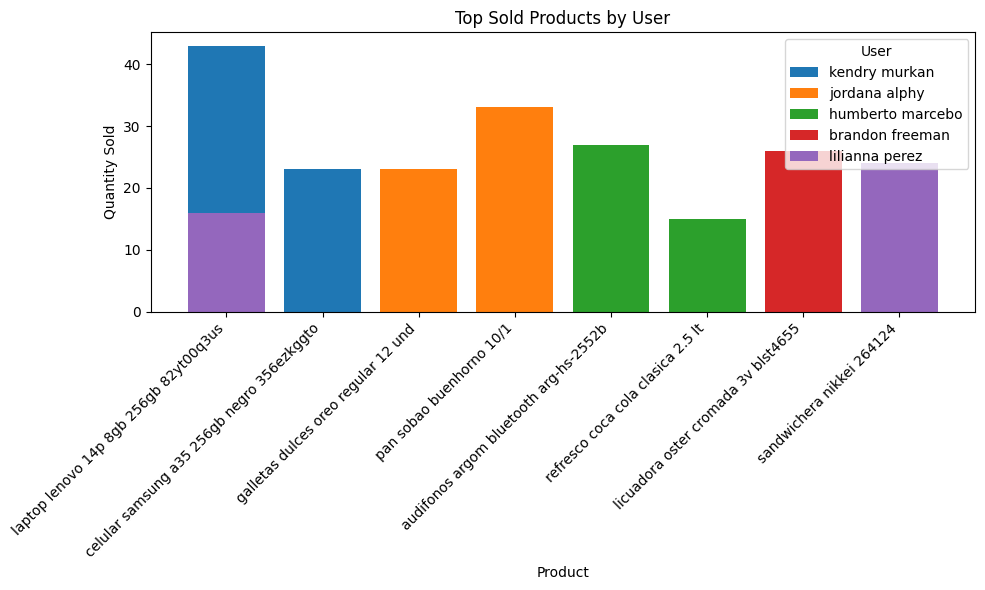

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

product_sales = order_data.groupby(['partner_invoice', 'product_name'])['quantity'].sum().reset_index()

top_products = product_sales.sort_values(by='quantity', ascending=False)

n = 10  
top_products = top_products.head(n)

plt.figure(figsize=(10, 6))
for user in top_products['partner_invoice'].unique():
    user_data = top_products[top_products['partner_invoice'] == user]
    plt.bar(user_data['product_name'], user_data['quantity'], label=user)

plt.xlabel('Product')
plt.ylabel('Quantity Sold')
plt.title('Top Sold Products by User')
plt.xticks(rotation=45, ha="right")
plt.legend(title="User", loc = 'upper right')
plt.tight_layout()
plt.show()



### k-Nearest Neighbors (KNN)
We scale and encode the data required for the KNN to function properly.

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

knn_features = order_data[["partner_invoice", "product_name", "category", "quantity", "unit_price"]]

knn_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ["partner_invoice", "product_name", "category"]),
        ('num', StandardScaler(), ['quantity', "unit_price"])
    ]
)

knn_processed_features = knn_preprocessor.fit_transform(knn_features)

We fit the model and check if it functions correctly. The focus here is to have it recommend products based on the individual. We use the cosine similarity metric to assess data similarities.

In [15]:
from sklearn.neighbors import NearestNeighbors

knn_model = NearestNeighbors(n_neighbors=2, metric="cosine")

knn_model.fit(knn_processed_features)

knn_user_index = order_data[order_data["partner_invoice"] == 'lilianna perez'].index[0]

distances, indices = knn_model.kneighbors(knn_processed_features[knn_user_index].reshape(1, -1))

knn_fav_products = order_data.iloc[indices[0]]['product_name']
print("📌 recommended product is: ")
print(knn_fav_products)
purchased_products = order_data[order_data['partner_invoice'] == 'lilianna perez']['product_name']
knn_recommended_not_purchase_products = knn_fav_products[~knn_fav_products.isin(purchased_products)]

print("\n 📌 recommended not purchase product is: ")
print(knn_recommended_not_purchase_products)




📌 recommended product is: 
0     celular samsung a35 256gb negro 356ezkggto
46    celular samsung a35 256gb negro 356ezkggto
Name: product_name, dtype: object

 📌 recommended not purchase product is: 
Series([], Name: product_name, dtype: object)


### Singular value decomposition
We decompose the interaction matrix into smaller matrices that represent the underlying latent factors explaining user preferences and product features. This decomposition allows us to recommend products that a user has not yet purchased, based on the behavioral patterns of similar users.

In [16]:

user_product_matrix = order_data.pivot_table(index='partner_invoice', columns='product_name', values='quantity', aggfunc='sum', fill_value=0)
scaler = StandardScaler()
user_product_matrix_scaled = scaler.fit_transform(user_product_matrix)
print(user_product_matrix_scaled)

[[-0.60436722 -0.75592895 -0.43285265 -0.68980898 -0.54160256  2.61819142
  -0.56478717 -0.1910184  -0.48078191 -0.35355339]
 [-0.60436722 -0.75592895 -0.88235348 -0.68980898 -0.17232809 -0.6406213
  -0.56478717 -0.62080978 -0.48078191  2.82842712]
 [ 2.65921578  2.0788046  -0.13318543 -0.68980898 -0.39389277 -0.51528235
  -0.46511885  2.60262564 -0.48078191 -0.35355339]
 [-0.36262033 -0.18898224 -0.58268626  2.28499225 -0.54160256  0.48742925
   2.72426753  0.45366869 -0.48078191 -0.35355339]
 [ 0.48349378  1.51185789 -0.73251987 -0.43113061 -0.54160256 -0.6406213
   0.23255942  0.23877299  0.19531765 -0.35355339]
 [ 0.         -0.75592895  2.56381956  1.1209396   2.63415791 -0.01392655
  -0.56478717 -0.62080978 -0.21034208 -0.35355339]
 [-0.48349378 -0.18898224  0.01664818 -0.68980898  0.64007575 -0.6406213
  -0.06644555 -0.62080978  2.76449596 -0.35355339]
 [-0.60436722 -0.18898224 -0.43285265  0.34490449 -0.54160256 -0.6406213
  -0.16611387 -0.62080978 -0.345562   -0.35355339]
 [-0

We reduce the dimensionality and retain the 5 most important components, then perform the transformation with the scaled data to prevent the dimensionality reduction from being influenced by high values. We apply a clip as a regularizer to avoid overfitting the data. The rows of Vt represent product latent features, while U represents the partners.

In [17]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

svd = TruncatedSVD(n_components=5)
svd_user_product_matrix = svd.fit_transform(user_product_matrix_scaled)

max_value = np.max(svd.singular_values_)
svd.singular_values_ = np.clip(svd.singular_values_, a_min=0, a_max=max_value * 0.5)  

U = svd_user_product_matrix
Sigma = svd.singular_values_
Vt = svd.components_

print("\n📌 Latent Users (U):")
print(U)
print("\n📌 Singular Values (Sigma):")
print(Sigma)
print("\n📌 Latent Products (Vt):")
print(Vt)


📌 Latent Users (U):
[[-0.76431586 -1.29418311 -0.11804568 -2.06784778 -1.5880001 ]
 [-0.84583514 -1.5785164  -2.04018053  0.13041331  1.96372146]
 [ 4.15045725  1.26647243 -0.26086549 -0.71242064  0.30487115]
 [ 0.08634475 -1.44186725  3.35052281  0.77135199  0.41441555]
 [ 1.680054   -0.15141826 -0.25453287  0.76397404 -0.28212737]
 [-2.21997804  3.04726036  0.87735339 -0.69536646  0.8295633 ]
 [-0.86656055  0.89708766 -1.08008145  2.12964626 -1.44499865]
 [-0.37488037 -0.6148897   0.03422428  0.3572644   0.09064219]
 [-0.84528604 -0.12994573 -0.50839445 -0.67701512 -0.28808753]]

📌 Singular Values (Sigma):
[2.64055967 2.64055967 2.64055967 2.64055967 2.64055967]

📌 Latent Products (Vt):
[[ 4.96421362e-01  5.34974839e-01 -2.44568401e-01 -1.37166080e-01
  -2.78714045e-01 -1.36038072e-01  5.22028505e-02  5.23020427e-01
  -8.34488799e-02 -9.65008805e-02]
 [ 3.02556574e-01  1.41042255e-01  5.85524424e-01  2.92157568e-02
   5.63328797e-01 -2.10098636e-01 -2.47029328e-01  1.00596429e-01
  

Matrix multiplication is a prediction because, by performing this operation, we are reconstructing an approximate version of the original matrix, the user-product interaction matrix. The key difference is that, through SVD decomposition, we can estimate interactions that have not been directly observed.

In [18]:
import numpy as np

Sigma_matrix = np.diag(Sigma)

predictions = np.dot(np.dot(U, Sigma_matrix), Vt)

predicted_ratings_df = pd.DataFrame(predictions, columns=user_product_matrix.columns, index=user_product_matrix.index)
print(predicted_ratings_df)




product_name        audifonos argom bluetooth arg-hs-2552b  \
partner_invoice                                              
brandon freeman                                  -1.776865   
harvard university                               -1.838017   
humberto marcebo                                  6.794311   
jordana alphy                                    -1.178445   
joshua barom                                      1.726329   
kendry murkan                                     0.019859   
lilianna perez                                   -1.605675   
milena garcia                                    -1.081994   
mylan ramos                                      -1.059503   

product_name        batidora cuisinart pedestal sm-50bc  \
partner_invoice                                           
brandon freeman                               -2.162077   
harvard university                            -1.900093   
humberto marcebo                               6.055864   
jordana alphy         

Then, we make the prediction and observe the user's favorite product as well as the one recommended to her.

In [19]:
user_name = 'lilianna perez'  
user_index = user_product_matrix.index.get_loc(user_name)
user_ratings = predicted_ratings_df.loc[user_name]  

unrated_products = user_product_matrix.loc[user_name] == 6  

svd_not_unrated_recommended_products = user_ratings[unrated_products]

print("📌 Top recommended products:")
print(svd_not_unrated_recommended_products.head())

svd_fav_products = user_ratings.sort_values(ascending=False)  

print("\n📌 fav products:")
print(svd_fav_products.head())



📌 Top recommended products:
product_name
celular samsung a35 256gb negro 356ezkggto    0.125704
Name: lilianna perez, dtype: float64

📌 fav products:
product_name
sandwichera nikkei 264124                     6.587164
laptop lenovo 14p 8gb 256gb 82yt00q3us        1.303330
celular samsung a35 256gb negro 356ezkggto    0.125704
batidora cuisinart pedestal sm-50bc          -0.008242
pan sobao buenhorno 10/1                     -0.471577
Name: lilianna perez, dtype: float64


### Export data

In [20]:
import pickle

order_data.to_parquet("../data/processed/order_data.parquet")

with open("../models/collaborative_filtering/svd_model.pkl", "wb") as f:
    pickle.dump((U, Sigma, Vt), f)

with open("../models/collaborative_filtering/knn_model.pkl", "wb") as f:
    pickle.dump(knn_model, f)